In [20]:
from ast import literal_eval

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D, Bidirectional, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from plotting import plot_confusion_matrix, plot_training_metrics
from sklearn.metrics import classification_report



### Prepare Data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df['tokens'] = train_df['tokens'].apply(literal_eval)
test_df['tokens'] = test_df['tokens'].apply(literal_eval)

max_len = train_df['n_ingredients'].max()
max_len

64

In [3]:
X_train = train_df['tokens'].apply(' '.join)
y_train = train_df['cuisine']
X_test = test_df['tokens'].apply(' '.join)
y_test = test_df['cuisine']

n_classes = y_train.nunique()

mapping = dict(zip(y_train.unique(), range(n_classes)))
print(mapping)

y_train = y_train.apply(lambda x: mapping[x]).values
y_test = y_test.apply(lambda x: mapping[x]).values

{'chinese': 0, 'italian': 1, 'mexican': 2, 'indian': 3, 'southern_us': 4}


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_len)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len)

In [5]:
vocab_size = len(word_index)
print('vocab size', vocab_size)
embedding_dim = 64

vocab size 1885


### Model Training

In [6]:
num_epochs = 100

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
checkpoint = ModelCheckpoint('models/recipes_tf', monitor="val_accuracy", save_best_only=True,
                                                verbose=1)

embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)

# We use GlobalAveragePooling because the order of the ingredients should not matter
model = Sequential([
    embedding,
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='sigmoid')
])
print(model.summary())

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_padded,
    y_train,
    validation_data=(testing_padded, y_test),
    epochs=num_epochs,
    batch_size=256,
    callbacks=[early_stopping, checkpoint]
)

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 64)            120640    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 122,885
Trainable params: 122,885
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100


2022-02-24 17:53:34.634945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-24 17:53:34.635032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-24 17:53:34.729039: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/76 [..............................] - ETA: 34s - loss: 1.6119 - accuracy: 0.1680

2022-02-24 17:53:34.995177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


76/76 [==============================] - ETA: 0s - loss: 1.5293 - accuracy: 0.3133
Epoch 1: val_accuracy improved from -inf to 0.32976, saving model to models/recipes_tf


2022-02-24 17:53:40.333355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 17:53:40.552647: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/recipes_tf/assets
76/76 [==============================] - 6s 76ms/step - loss: 1.5293 - accuracy: 0.3133 - val_loss: 1.4624 - val_accuracy: 0.3298
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 1.3665 - accuracy: 0.4126
Epoch 2: val_accuracy improved from 0.32976 to 0.56107, saving model to models/recipes_tf
INFO:tensorflow:Assets written to: models/recipes_tf/assets
76/76 [==============================] - 5s 70ms/step - loss: 1.3665 - accuracy: 0.4126 - val_loss: 1.2046 - val_accuracy: 0.5611
Epoch 3/100
76/76 [==============================] - ETA: 0s - loss: 0.9773 - accuracy: 0.6979
Epoch 3: val_accuracy improved from 0.56107 to 0.80453, saving model to models/recipes_tf
INFO:tensorflow:Assets written to: models/recipes_tf/assets
76/76 [==============================] - 5s 72ms/step - loss: 0.9773 - accuracy: 0.6979 - val_loss: 0.7666 - val_accuracy: 0.8045
Epoch 4/100
76/76 [==============================] - ETA: 0s

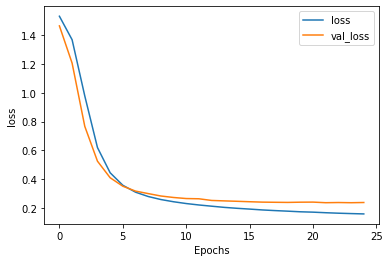

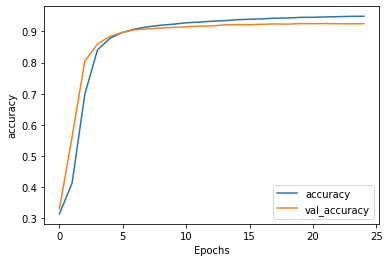

In [7]:
plot_training_metrics(history, 'loss')
plot_training_metrics(history, 'accuracy')

### Model validation

In [15]:
y_pred = tf.argmax(model.predict(testing_padded), axis=-1)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       536
           1       0.92      0.95      0.93      1600
           2       0.95      0.91      0.93      1259
           3       0.95      0.96      0.95       588
           4       0.85      0.87      0.86       872

    accuracy                           0.93      4855
   macro avg       0.93      0.93      0.93      4855
weighted avg       0.93      0.93      0.93      4855



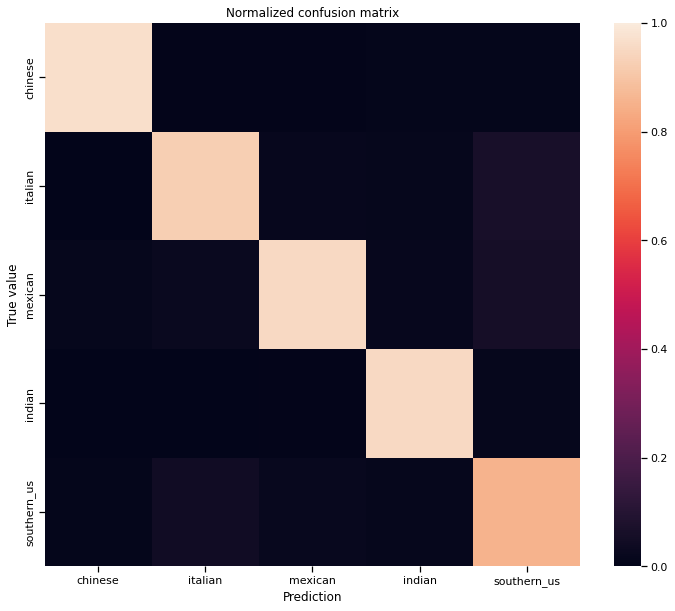

In [17]:
plot_confusion_matrix(y_test, y_pred, mapping.keys())

### Visualize Test Set Recipes

In [80]:
recipe_vectors = tf.reduce_sum(embedding(testing_padded), axis=-2)

In [78]:
tsne = TSNE(perplexity=4, n_components=2,  n_iter=3500)
tsne_vectors = tsne.fit_transform(recipe_vectors)

/opt/homebrew/Caskroom/miniforge/base/envs/itp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/itp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


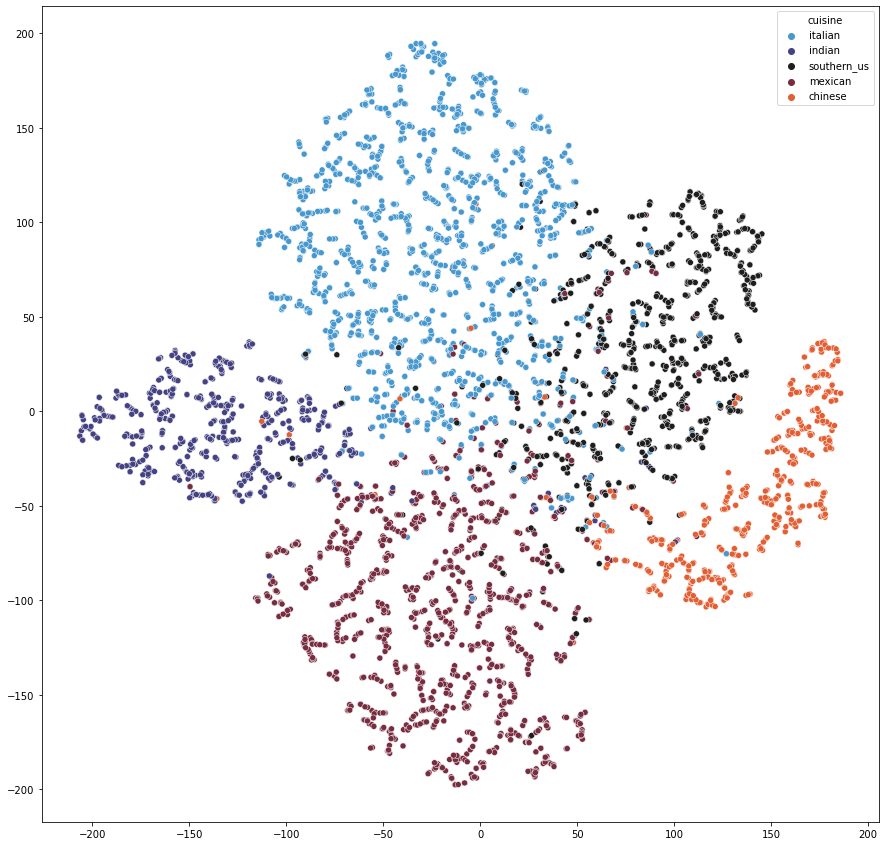

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
sns.scatterplot(x=tsne_vectors[:,0], y=tsne_vectors[:,1], hue=test_df['cuisine'], legend=mapping.keys(), palette='icefire')
plt.show()

### Model with LSTM
LSTMs use the order of the words so we do some data augmentation to randomize the orders

In [91]:
import random

n_times = 10
augmented = X_train.copy().tolist()

def shuffle_ingredients(ingredients_str):
    ingredients_list = ingredients_str.split()
    ingredients_list = random.sample(ingredients_list, len(ingredients_list))
    return ' '.join(ingredients_list)

for i in range(n_times):
    augmented.extend([shuffle_ingredients(ingredients_str) for ingredients_str in X_train])


y_train_aug = np.concatenate([y_train] * (n_times + 1))

# Sanity check
print(len(augmented), len(y_train_aug))
print(augmented[0], y_train_aug[0])
print(augmented[len(X_train)], y_train_aug[len(X_train)])

augmented = np.array(augmented)

train_sequences_aug = tokenizer.texts_to_sequences(augmented)
train_padded_aug = pad_sequences(train_sequences_aug, maxlen=max_len)

213587 213587
chily ginger pepper scallion vinegar orange garlic soy canola clove flake sauce sodium molasse jalapeno starch navel sesame steak corn rice oil 0
rice sodium chily molasse oil clove canola corn sesame flake steak scallion ginger pepper sauce navel vinegar orange garlic soy jalapeno starch 0


In [94]:
embedding_lstm = Embedding(vocab_size, embedding_dim, input_length=max_len)

model_lstm = Sequential([
    embedding,
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='sigmoid')
])
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model_lstm.fit(
    train_padded_aug,
    y_train_aug,
    validation_data=(testing_padded, y_test),
    epochs=1,
    batch_size=256
)

2022-02-24 19:40:03.552666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:40:04.024130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:40:04.038056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:40:04.344066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:40:04.370252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:40:04.745035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:40:04.761662: I tensorflow/core/grappler/optimizers/cust

835/835 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9560

2022-02-24 19:42:19.042289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:42:19.188737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:42:19.197818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:42:19.362930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:42:19.370867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


835/835 [==============================] - 140s 162ms/step - loss: 0.1469 - accuracy: 0.9560 - val_loss: 0.3204 - val_accuracy: 0.9217


This reaches the around the same accuracy as the previous model in just one epoch


In [96]:
preds_lstm = tf.argmax(model_lstm.predict(testing_padded), axis=-1)

2022-02-24 19:47:31.991006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:47:32.338492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:47:32.353525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:47:32.789423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:47:32.803700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [97]:
print(classification_report(y_test, preds_lstm))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       536
           1       0.92      0.95      0.94      1600
           2       0.94      0.92      0.93      1259
           3       0.93      0.96      0.95       588
           4       0.86      0.84      0.85       872

    accuracy                           0.92      4855
   macro avg       0.92      0.92      0.92      4855
weighted avg       0.92      0.92      0.92      4855

